# Data Understanding
## Bank Customer Segmentation
Most banks have a large customer base - with different characteristics in terms of age, income, values, lifestyle, and more. Customer segmentation is the process of dividing a customer dataset into specific groups based on shared traits.

## About this Dataset
This dataset consists of 1 Million+ transaction by over 800K customers for a bank in India. The data contains information such as - customer age (DOB), location, gender, account balance at the time of the transaction, transaction details, transaction amount, etc.

## Interesting Analysis Ideas
The dataset can be used for different analysis, example:
1. Customer Recency, Frequency, Monetary analysis
2. Perform Clustering / Segmentation on the dataset and identify popular customer groups along with their definitions/rules.

# Import Python Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re
from sklearn. preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [2]:
df = pd.read_csv("../data/raw/bank_transactions.csv.zip")

In [3]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


# Data Preparation (Creating RMF Dataframe)

### Convert to Datetime

In [4]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format = '%d/%m/%y')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format = '%d/%m/%y')

### Creating First and Last Transaction Date Columns

In [5]:
df['TransactionDateFirst'] = df['TransactionDate'] # first transaction
df['TransactionDateLast'] = df['TransactionDate'] # last transaction
df['CustomerAge'] = df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

### Creating MRF Dataframe

In [6]:
#Creating RMF Dataframe
RMF_df = df.groupby("CustomerID").agg({
    "TransactionID" : "count",
    "CustGender" : "first",
    "CustLocation":"first",
    "CustAccountBalance"  : "mean",
    "TransactionAmount (INR)" : "mean",
    "CustomerAge" : "median",
    "TransactionDateFirst":"min",
    "TransactionDateLast":"max",
    "TransactionDate":"median"
    })
RMF_df = RMF_df.reset_index()

### Creating Frequency and Recency Columns

In [7]:
RMF_df.rename(columns={"TransactionID":"Frequency"},inplace=True)
RMF_df['Recency']=RMF_df['TransactionDateLast']-RMF_df['TransactionDateFirst']
RMF_df['Recency']=RMF_df['Recency'].astype(str)
RMF_df['Recency']=RMF_df['Recency'].apply(lambda x :re.search('\d+',x).group())
RMF_df['Recency']=RMF_df['Recency'].astype(int)
def rep_0(i):
    if i==0:
        return 1 # 0 days mean that a customer has done transaction recently one time by logic so I will convert 0 to 1
    else:
        return i
RMF_df['Recency'] = RMF_df['Recency'].apply(rep_0)

### Droping Unnecessary Columns

In [8]:
RMF_df.drop(columns=["TransactionDateFirst",
                     "TransactionDateLast",
                     "CustomerID",
                      "CustLocation",
                      "TransactionDate",
                      ],
                     inplace=True)
RMF_df = RMF_df.reset_index(drop=True)

### Using only 100000 rows

In [9]:
# the data is very very big so I will use only 100000 rows
RMF_df = RMF_df.sample(n=10000, random_state=42).reset_index(drop=True)

# Data Preprocessing

### Handling Missing Values

In [10]:
RMF_df["CustGender"].fillna(RMF_df["CustGender"].mode()[0], inplace=True)
RMF_df["CustomerAge"].fillna(RMF_df["CustomerAge"].median(), inplace=True)
RMF_df["CustAccountBalance"].fillna(RMF_df["CustAccountBalance"].median(), inplace=True)

### Encode Categorical Data

In [11]:
RMF_df['CustGender']=RMF_df['CustGender'].map({'M':1,'F':0})

### Handling Negative Values

In [12]:
def remove_negative_values(dataframe):
    # Mengambil semua kolom dalam DataFrame
    columns = dataframe.columns
    # Menghapus nilai negatif dalam setiap kolom
    for column in columns:
        dataframe[column] = dataframe[column].apply(lambda x: max(x, 0))
    return dataframe
RMF_df = remove_negative_values(RMF_df)

### Standardization

In [13]:
# data scaling
df_scaled=StandardScaler().fit_transform(RMF_df)
df_scaled=pd.DataFrame(df_scaled,columns=RMF_df.columns)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,-0.403018,-1.563178,-0.163635,-0.319841,0.347834,-0.332752
1,-0.403018,0.639722,0.006258,-0.322280,0.347834,-0.332752
2,-0.403018,0.639722,-0.126158,-0.216154,0.896771,-0.332752
3,-0.403018,0.639722,-0.169020,-0.336911,-0.640253,-0.332752
4,-0.403018,0.639722,-0.174488,-0.075985,0.238047,-0.332752


# Modelling (K-Means)

- The k-means clustering is a method of vector quantization, originally from signal processing, that
- The Elbow method is a graphical representation of finding the optimal 'K' in a K-means cluster

In [14]:
# instatiate the clustering model and visualizer
cluster_model = KMeans(random_state=42)

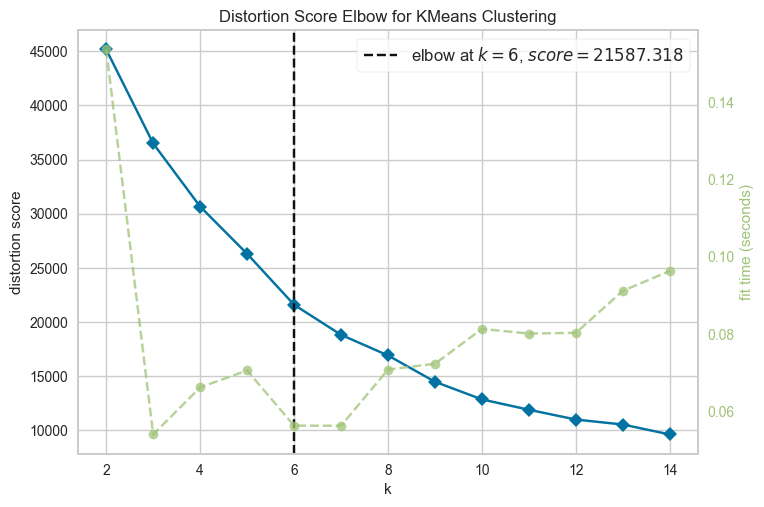

In [15]:
visualizer = KElbowVisualizer(cluster_model, k=(2, 15))
visualizer.fit(df_scaled)  # fit the data to the visualizer
visualizer.show()  # finalize and render the figure
plt.show()

,n_clusters,average_scores
0,7,0.533662
1,6,0.532008
2,2,0.495609
3,5,0.487567
4,4,0.482888
5,10,0.476134
6,8,0.468370
7,3,0.466495
8,9,0.465614


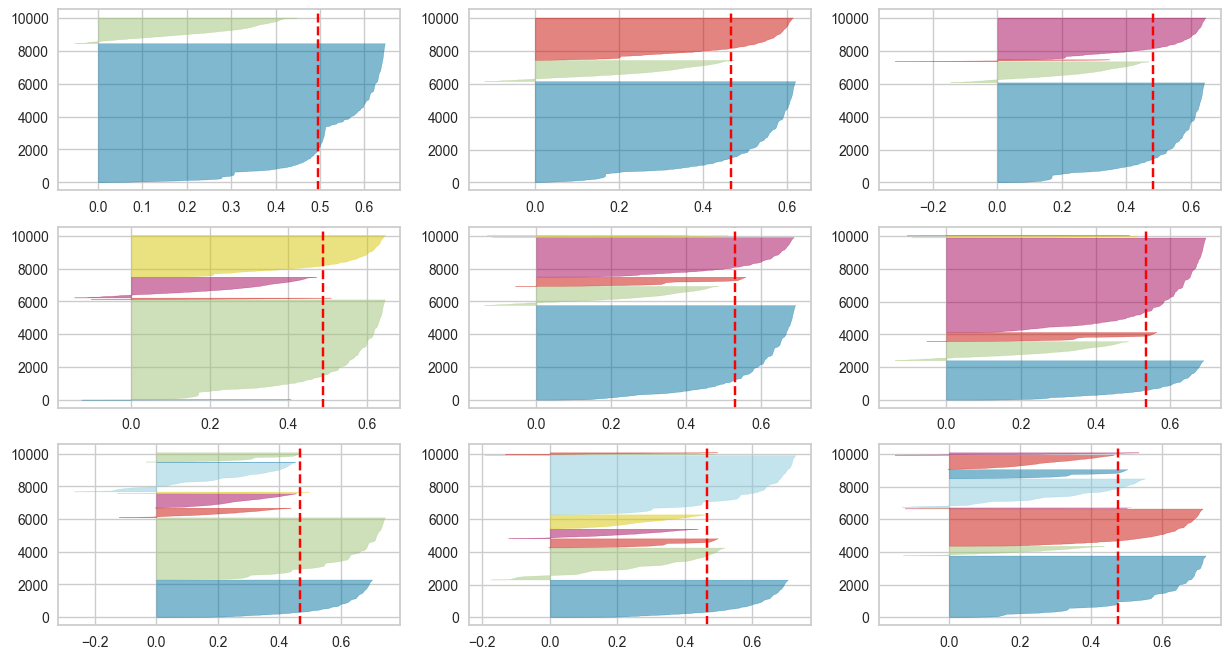

In [16]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

k_range = list(range(2, 11))
lst_scores = []

fig, axs = plt.subplots(3, 3, figsize=(15, 8))
for k, ax_i in zip(
    k_range, [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
):
    """
    Create KMeans instances for different number of clusters
    """
    cluster_model = KMeans(n_clusters=k, random_state=42)
    """
    Print the Silhoutte Score
    """
    preds = cluster_model.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, preds)
    lst_scores.append(score)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    q = ax_i[0]
    mod = ax_i[1]
    visualizer = SilhouetteVisualizer(
        cluster_model, colors="yellowbrick", ax=axs[q][mod]
    )
    visualizer.fit(df_scaled)

df_sillhoutte = pd.DataFrame(
    list(zip(k_range, lst_scores)), columns=["n_clusters", "average_scores"]
)
df_sillhoutte.sort_values("average_scores", inplace=True, ascending=False)
df_sillhoutte.reset_index(drop=True)

In [17]:
kmeans = KMeans(n_clusters=6)    
kmeans.fit(df_scaled)
df_scaled['Label']=kmeans.labels_
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency,Label
0,-0.403018,-1.563178,-0.163635,-0.319841,0.347834,-0.332752,0
1,-0.403018,0.639722,0.006258,-0.322280,0.347834,-0.332752,2
2,-0.403018,0.639722,-0.126158,-0.216154,0.896771,-0.332752,2
3,-0.403018,0.639722,-0.169020,-0.336911,-0.640253,-0.332752,2
4,-0.403018,0.639722,-0.174488,-0.075985,0.238047,-0.332752,2


# Cluster Analysis

In [18]:
def plot_cluster(n_cluster):
    cluster = df_scaled[df_scaled['Label']==n_cluster].loc[:,:"Recency"]

    fig = px.line_polar(cluster,
                        r = cluster.mean().tolist(),
                        theta = cluster.columns.tolist(),
                        line_close = True)
    fig.update_layout(
        title="Cluster {}".format(n_cluster),
    )
    fig.show()

for i in range(0,6):
    plot_cluster(i)